In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [26]:

# Load data
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)


In [27]:

# Read sheets into DataFrames
customers_df = pd.read_excel(xls, sheet_name="customers")
transactions_df = pd.read_excel(xls, sheet_name="transactions")
genders_df = pd.read_excel(xls, sheet_name="genders")
cities_df = pd.read_excel(xls, sheet_name="cities")

In [28]:

# Merge customers with genders and cities
customers_df = customers_df.merge(genders_df, on="gender_id", how="left")
customers_df = customers_df.merge(cities_df, on="city_id", how="left")
customers_df.drop(columns=["gender_id", "city_id"], inplace=True)

# Aggregate transaction data
transaction_summary = transactions_df.groupby("customer_id").agg(
    total_transactions=("transaction_id", "count"),
    unique_coupons=("coupon_name", "nunique"),
    burned_coupons=("transaction_status", lambda x: (x == "burned").sum())
).reset_index()

# Merge with customer data
customer_data = customers_df.merge(transaction_summary, on="customer_id", how="left")
customer_data.fillna(0, inplace=True)

In [29]:

# Select features for clustering
features = customer_data[["total_transactions", "unique_coupons", "burned_coupons"]]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal K using Elbow Method
sse = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)


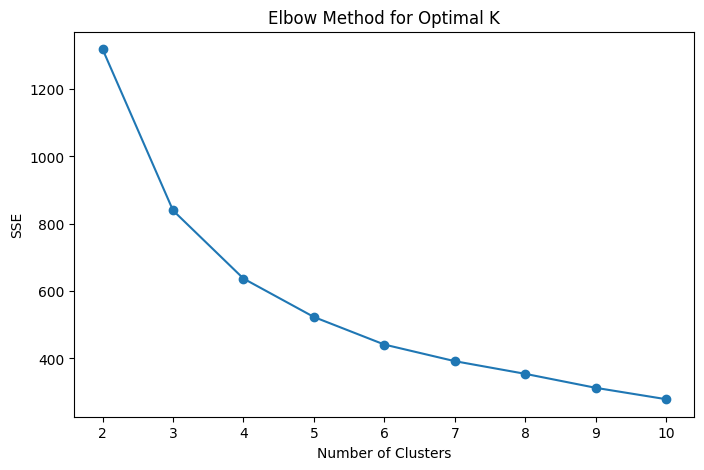

In [30]:

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()


In [31]:

# Train K-Means with optimal K (Assume 4 from elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to customer data
customer_data["KMeans_Cluster"] = kmeans_labels


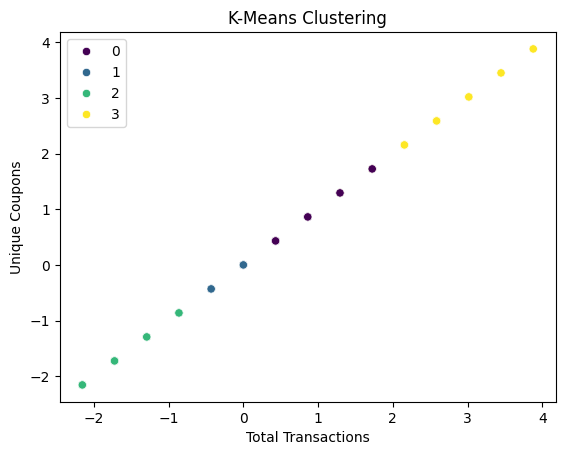

In [32]:

# Visualizing Clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=kmeans_labels, palette='viridis')
plt.xlabel('Total Transactions')
plt.ylabel('Unique Coupons')
plt.title('K-Means Clustering')
plt.show()


In [35]:

# Evaluate Clustering Model
silhouette_kmeans = silhouette_score(scaled_features, kmeans_labels)
print(f'Silhouette Score for K-Means: {silhouette_kmeans:.4f}')

# Cluster Segment Analysis
segment_summary = customer_data.groupby("KMeans_Cluster").agg(
    avg_transactions=("total_transactions", "mean"),
    avg_unique_coupons=("unique_coupons", "mean"),
    avg_burned_coupons=("burned_coupons", "mean"),
    customer_count=("customer_id", "count")
).reset_index()

print("\nSegment Analysis for K-Means Clusters:")
print(segment_summary)

Silhouette Score for K-Means: 0.3929

Segment Analysis for K-Means Clusters:
   KMeans_Cluster  avg_transactions  avg_unique_coupons  avg_burned_coupons  \
0               0          6.469751            6.469751            3.316726   
1               1          4.334190            4.334190            2.128535   
2               2          2.004739            2.004739            0.763033   
3               3          9.016807            9.016807            5.000000   

   customer_count  
0             281  
1             389  
2             211  
3             119  


In [37]:

# Coupon Distribution Recommendations
print("\nCoupon Distribution Recommendations:")
for _, row in segment_summary.iterrows():
    cluster = row["KMeans_Cluster"]
    print(f"Cluster {cluster}:")
    if row["avg_transactions"] > 5:
        print("- Loyal Customers: Offer exclusive rewards and high-value coupons.")
    elif row["avg_unique_coupons"] > 3:
        print("- Deal Seekers: Use targeted discounts and cashback offers.")
    elif row["avg_transactions"] > 2:
        print("- Occasional Shoppers: Provide personalized recommendations and limited-time discounts.")
    else:
        print("- Inactive Customers: Use win-back campaigns with attractive offers.")



Coupon Distribution Recommendations:
Cluster 0.0:
- Loyal Customers: Offer exclusive rewards and high-value coupons.
Cluster 1.0:
- Deal Seekers: Use targeted discounts and cashback offers.
Cluster 2.0:
- Occasional Shoppers: Provide personalized recommendations and limited-time discounts.
Cluster 3.0:
- Loyal Customers: Offer exclusive rewards and high-value coupons.


In [41]:
# Coupon Distribution Recommendations
print("\nCoupon Distribution Recommendations:")
for _, row in segment_summary.iterrows():
    cluster = row["KMeans_Cluster"]
    print(f"Cluster {cluster}:")

    # Refined logic for better differentiation
    if row["avg_transactions"] > 5 and row["avg_unique_coupons"] > 3:
        print("- Loyal Customers: Offer exclusive rewards and high-value coupons.")
    elif row["avg_unique_coupons"] > 3 and row["avg_transactions"] <= 2:
        print("- Deal Seekers: Use targeted discounts and cashback offers.")
    elif row["avg_transactions"] > 2 and row["avg_unique_coupons"] <= 3:
        print("- Occasional Shoppers: Provide personalized recommendations and limited-time discounts.")
    else:
        print("- Inactive Customers: Use win-back campaigns with attractive offers.")



Coupon Distribution Recommendations:
Cluster 0.0:
- Loyal Customers: Offer exclusive rewards and high-value coupons.
Cluster 1.0:
- Inactive Customers: Use win-back campaigns with attractive offers.
Cluster 2.0:
- Occasional Shoppers: Provide personalized recommendations and limited-time discounts.
Cluster 3.0:
- Loyal Customers: Offer exclusive rewards and high-value coupons.
